In [1]:
# import libraries
import time
import os
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import explode
from IPython.display import Image
import matplotlib.pyplot as plt

Add a bit of interactivity

In [2]:
import ipywidgets as widgets

In [3]:
display(output_recs)

NameError: name 'output_recs' is not defined

# Start up spark cluster

In [4]:
appName="Collaborative Filtering with PySpark"
# initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()
# get sparkcontext from the sparksession
sc = spark.sparkContext

# Load in Data and split into Train and Test

In [5]:
def load_dataset(path):
    #define schema
    schema = StructType([
        StructField("item", StringType(), True),
        StructField("user", StringType(), True),
        StructField("rating", StringType(), True),
        StructField("timestamp", IntegerType(), True)])

    df = spark.read.csv(path ,header=False,schema=schema)
    df = df.withColumn("rating", df["rating"].cast(IntegerType()))
    
    #provide index values for item and user to convert them into integers
    stringIndexer = StringIndexer(inputCols=["item","user"], outputCols=["itemIndex","userIndex"])
    model = stringIndexer.fit(df)
    df = model.transform(df)
    
    #df = df.withColumn("userIndex", df["userIndex"].cast(IntegerType()))
    
    return df

In [6]:
fname = 'Software'
path = r'./ratings_data/{}.csv'.format(fname)
df = load_dataset(path)
df.printSchema()

test_fraction = .35

training, test = df.randomSplit([1-test_fraction, test_fraction])

print('- training df -')
training.show(n=5)

print('- test df -')
test.show(n=5)

root
 |-- item: string (nullable = true)
 |-- user: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- itemIndex: double (nullable = false)
 |-- userIndex: double (nullable = false)

- training df -
+----------+--------------+------+----------+---------+---------+
|      item|          user|rating| timestamp|itemIndex|userIndex|
+----------+--------------+------+----------+---------+---------+
|0077613252|A1YCCU0YRLS0FE|     4|1393113600|   3637.0| 133125.0|
|0077613252| APRDVZ6QBIQXT|     3|1392595200|   3637.0| 350871.0|
|0132147556|A1M4P30L5OACAI|     3|1371427200|   2311.0|  20612.0|
|0132147556|A1N8M648G5E2BM|     1|1335916800|   2311.0| 106636.0|
|0132147556|A1OU9LR6C03LNB|     2|1371945600|   2311.0| 110492.0|
+----------+--------------+------+----------+---------+---------+
only showing top 5 rows

- test df -
+----------+--------------+------+----------+---------+---------+
|      item|          user|rating| timestamp

# Define ALS object

In [7]:
als = ALS(maxIter=15, 
          implicitPrefs=False,
          regParam=0.25,
          userCol="userIndex", 
          itemCol="itemIndex", 
          ratingCol="rating",
          coldStartStrategy="drop")

- Need to tinker with hyperparameters (for ALS, train-test split, etc)
- need to regularize
- Use metrics to evaluate fit (right now we are overfitting)
- assign USERS to train-test dfs (not observations)

In [8]:
model = als.fit(training)

In [9]:
predictions = model.transform(test)
predictions.show(10)

predictions_train = model.transform(training)
predictions_train.show(5)

+----------+--------------+------+----------+---------+---------+----------+
|      item|          user|rating| timestamp|itemIndex|userIndex|prediction|
+----------+--------------+------+----------+---------+---------+----------+
|B015724B8M|A1Q57PPAR0MQDD|     5|1475020800|    148.0|  21682.0| 4.0159373|
|B015724B8M|A1V9URY58AWPER|     5|1523059200|    148.0|  23100.0|  4.058794|
|B015724B8M|A2JX9X0RMD9632|     5|1476144000|    148.0|  29715.0| 4.0159373|
|B015724B8M|A3MGPEAUXD0JNK|     5|1462147200|    148.0|   5592.0| 4.0951076|
|B015724B8M| AYUH7SGZNCVAY|     3|1503014400|    148.0|  14669.0| 0.6195186|
|B015724B8M|A16EJMOWU76BNE|     1|1522713600|    148.0|   6924.0|0.76081455|
|B015724B8M|A3DXYKQQSRYOP1|     5|1478044800|    148.0|   2998.0| 4.3059855|
|B015724B8M|A2JZWS54E82TS1|     5|1493424000|    148.0|  29737.0| 3.7670693|
|B015724B8M|A1FTQN6EPPCAUP|     5|1454284800|    148.0|   3923.0|  4.126901|
|B015724B8M|A1JWKY3Y3GPNCX|     4|1506038400|    148.0|  19967.0| 1.9163489|

In [10]:
evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="rmse")

test_rmse = evaluator.evaluate(predictions_train)
train_rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on training data = {train_rmse}")
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse}")

Root Mean Squared Error (RMSE) on training data = 2.5170439677720697
Root Mean Squared Error (RMSE) on test data = 0.285588542038623


In [11]:
evaluator = RegressionEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="mae")

test_mae = evaluator.evaluate(predictions_train)
train_mae = evaluator.evaluate(predictions)

print(f"mae on training data = {train_mae}")
print(f"mae on test data = {test_mae}")

mae on training data = 1.9298181817288003
mae on test data = 0.24636456026321105


# Iterate over regparams, and record RMSE for each.

In [12]:
results = []

for lambda_ in np.arange(.1,.7, .05):
    print(f'regParam = {lambda_}')
    als = ALS(maxIter=5, 
          implicitPrefs=False,
          regParam=lambda_,
          userCol="userIndex", 
          itemCol="itemIndex", 
          ratingCol="rating",
          coldStartStrategy="drop")
    
    model = als.fit(training)
    
    predictions = model.transform(test)
    predictions_train = model.transform(training)
    
    test_rmse = evaluator.evaluate(predictions)
    train_rmse = evaluator.evaluate(predictions_train)
    
    results.append([lambda_, train_rmse, test_rmse])
    
reg_df = pd.DataFrame(results, columns=['regParam', 'train_rmse', 'test_rmse'])
reg_df

regParam = 0.1
regParam = 0.15000000000000002
regParam = 0.20000000000000004
regParam = 0.25000000000000006
regParam = 0.30000000000000004
regParam = 0.3500000000000001
regParam = 0.40000000000000013
regParam = 0.45000000000000007
regParam = 0.5000000000000001
regParam = 0.5500000000000002
regParam = 0.6000000000000002
regParam = 0.6500000000000001


,regParam,train_rmse,test_rmse
0,0.10,0.256410,3.939733
1,0.15,0.315088,3.556023
2,0.20,0.361242,3.379211
3,0.25,0.400087,3.337085
4,0.30,0.434797,3.376011
5,0.35,0.467911,3.454805
6,0.40,0.501619,3.547261
7,0.45,0.537642,3.639138
8,0.50,0.577046,3.723506
9,0.55,0.620247,3.797553


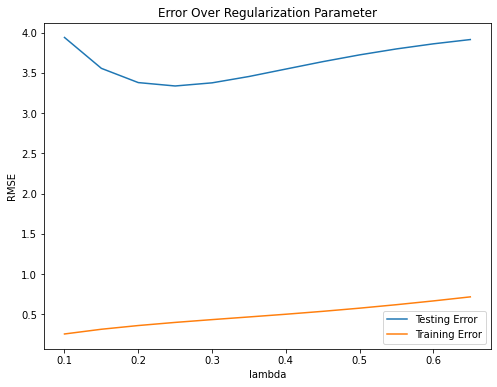

In [13]:
plt.figure(figsize=(8,6))
plt.plot(reg_df.regParam, reg_df.test_rmse)
plt.plot(reg_df.regParam, reg_df.train_rmse)

plt.ylabel('RMSE')
plt.xlabel('lambda')
plt.title('Error Over Regularization Parameter')
plt.legend(['Testing Error', 'Training Error'])
plt.savefig(r'./figures/regParam.png')

Slightly better

In [14]:
results = []
lambda_ = .25

for maxIter in range(5,25,5):
    print(f'maxIter = {maxIter}')
    als = ALS(maxIter=maxIter, 
          implicitPrefs=False,
          regParam=lambda_,
          userCol="userIndex", 
          itemCol="itemIndex", 
          ratingCol="rating",
          coldStartStrategy="drop")
    
    model = als.fit(training)
    
    predictions = model.transform(test)
    predictions_train = model.transform(training)
    
    test_rmse = evaluator.evaluate(predictions)
    train_rmse = evaluator.evaluate(predictions_train)
    
    results.append([maxIter, train_rmse, test_rmse])
    
iter_df = pd.DataFrame(results, columns=['maxIter', 'train_rmse', 'test_rmse'])
iter_df

maxIter = 5
maxIter = 10
maxIter = 15
maxIter = 20


,maxIter,train_rmse,test_rmse
0,5,0.400087,3.337085
1,10,0.294014,2.491132
2,15,0.270857,2.050679
3,20,0.264530,1.778208


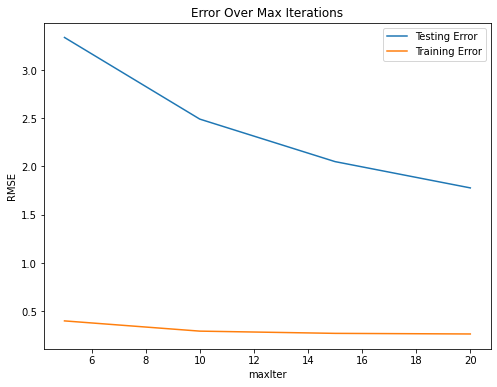

In [15]:
plt.figure(figsize=(8,6))
plt.plot(iter_df.maxIter, iter_df.test_rmse)
plt.plot(iter_df.maxIter, iter_df.train_rmse)
plt.ylabel('RMSE')
plt.xlabel('maxIter')
plt.title('Error Over Max Iterations')
plt.legend(['Testing Error', 'Training Error'])
plt.savefig(r'./figures/maxIter.png')

In [16]:
results = []
for block in range(10,110,10):
    print(block)
    start_time = time.time()
    als = ALS(maxIter=20, 
              implicitPrefs=False,
              regParam=.25,
              userCol="userIndex", 
              itemCol="itemIndex",
              numUserBlocks=block, #parallel
              numItemBlocks=10, #parallel
              ratingCol="rating",
              coldStartStrategy="drop")

    model = als.fit(training)

    predictions = model.transform(test)
    predictions_train = model.transform(training)

    test_rmse = evaluator.evaluate(predictions)
    train_rmse = evaluator.evaluate(predictions_train)
    
    total_time = time.time() - start_time
    
    results.append([block, total_time, train_rmse, test_rmse])

    print(train_rmse, test_rmse, total_time)
    
user_blocks = pd.DataFrame(results, columns = ['block', 'total_time', 'train_rmse', 'test_rmse'])
user_blocks

10
0.2645295466876586 1.7782079294275652 65.07864189147949
20
0.26456436019415625 1.8882628100356258 73.76846551895142
30
0.2638666598026787 1.715384121795668 85.3313479423523
40
0.2646131811830349 1.744883988886635 96.819908618927
50
0.26445529100940424 1.7251428427959943 105.85895609855652
60
0.2646506869037249 1.8343911042698453 114.47665023803711
70
0.2639769283257781 1.7224157678180858 125.32689952850342
80
0.2646609537771081 1.845172470792509 135.86552667617798
90
0.2641753587412408 1.6583041916197747 145.38541531562805
100
0.2643378673928724 1.69179478760077 152.9412660598755


,block,total_time,train_rmse,test_rmse
0,10,65.078642,0.264530,1.778208
1,20,73.768466,0.264564,1.888263
2,30,85.331348,0.263867,1.715384
3,40,96.819909,0.264613,1.744884
4,50,105.858956,0.264455,1.725143
5,60,114.476650,0.264651,1.834391
6,70,125.326900,0.263977,1.722416
7,80,135.865527,0.264661,1.845172
8,90,145.385415,0.264175,1.658304
9,100,152.941266,0.264338,1.691795


In [17]:
user_blocks

,block,total_time,train_rmse,test_rmse
0,10,65.078642,0.264530,1.778208
1,20,73.768466,0.264564,1.888263
2,30,85.331348,0.263867,1.715384
3,40,96.819909,0.264613,1.744884
4,50,105.858956,0.264455,1.725143
5,60,114.476650,0.264651,1.834391
6,70,125.326900,0.263977,1.722416
7,80,135.865527,0.264661,1.845172
8,90,145.385415,0.264175,1.658304
9,100,152.941266,0.264338,1.691795


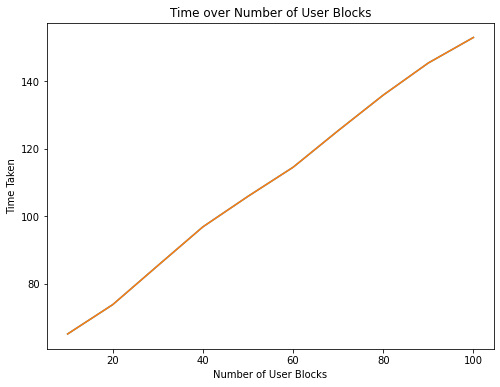

In [18]:
plt.figure(figsize=(8,6))
plt.plot(user_blocks.block, user_blocks.total_time)
plt.plot(user_blocks.block, user_blocks.total_time)
plt.ylabel('Time Taken')
plt.xlabel('Number of User Blocks')
plt.title('Time over Number of User Blocks')
plt.savefig(r'./figures/userBlocks.png')

In [19]:
results = []
for block in range(10,110,10):
    print(block)
    start_time = time.time()
    als = ALS(maxIter=20, 
              implicitPrefs=False,
              regParam=.25,
              userCol="userIndex", 
              itemCol="itemIndex",
              numUserBlocks=10, #parallel
              numItemBlocks=block, #parallel
              ratingCol="rating",
              coldStartStrategy="drop")

    model = als.fit(training)

    predictions = model.transform(test)
    predictions_train = model.transform(training)

    test_rmse = evaluator.evaluate(predictions)
    train_rmse = evaluator.evaluate(predictions_train)
    
    total_time = time.time() - start_time
    
    results.append([block, total_time, train_rmse, test_rmse])

    print(train_rmse, test_rmse, total_time)
    
item_blocks = pd.DataFrame(results, columns = ['block', 'total_time', 'train_rmse', 'test_rmse'])

10
0.2645295466876586 1.7782079294275652 65.72912430763245
20
0.2645295466876586 1.7782079294275652 75.12798643112183
30
0.2645295466876586 1.7782079294275652 86.5610716342926
40
0.2645295466876586 1.7782079294275652 96.47478914260864
50
0.2645295466876586 1.7782079294275652 105.18139696121216
60
0.2645295466876586 1.7782079294275652 115.67884135246277
70
0.2645295466876586 1.7782079294275652 122.94124221801758
80
0.2645295466876586 1.7782079294275652 134.0386929512024
90
0.2645295466876586 1.7782079294275652 142.4848599433899
100
0.2645295466876586 1.7782079294275652 152.35680103302002


In [20]:
item_blocks

,block,total_time,train_rmse,test_rmse
0,10,65.729124,0.26453,1.778208
1,20,75.127986,0.26453,1.778208
2,30,86.561072,0.26453,1.778208
3,40,96.474789,0.26453,1.778208
4,50,105.181397,0.26453,1.778208
5,60,115.678841,0.26453,1.778208
6,70,122.941242,0.26453,1.778208
7,80,134.038693,0.26453,1.778208
8,90,142.484860,0.26453,1.778208
9,100,152.356801,0.26453,1.778208


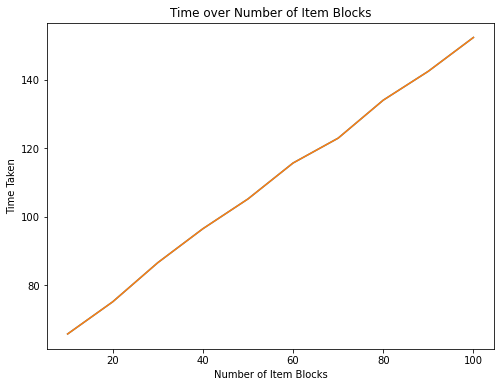

In [21]:
plt.figure(figsize=(8,6))
plt.plot(item_blocks.block, item_blocks.total_time)
plt.plot(item_blocks.block, item_blocks.total_time)
plt.ylabel('Time Taken')
plt.xlabel('Number of Item Blocks')
plt.title('Time over Number of Item Blocks')
plt.savefig(r'./figures/itemBlocks.png')

In [22]:
def topLikes(dataframe,userIndex,limit):
    likes_df = dataframe.filter(dataframe.userIndex==userIndex)\
    .sort(dataframe.rating.desc())\
    .select(dataframe.userIndex,dataframe.itemIndex,dataframe.rating)\
    .limit(limit)
    return likes_df
# display top liked items for a user
topLikes(df,9386,10).show(truncate=False)

+---------+---------+------+
|userIndex|itemIndex|rating|
+---------+---------+------+
|9386.0   |463.0    |5     |
|9386.0   |53.0     |4     |
+---------+---------+------+



In [23]:
def recommendedItems(userIndex,n):
    test = model.recommendForAllUsers(n)\
        .filter(col('userIndex')==userIndex)\
        .select(["recommendations.itemIndex","recommendations.rating"])
        #.collect()
        #\
        
    return test
# display top n recommended artists for user 2062243
recs = recommendedItems(9386,6)
recs

DataFrame[itemIndex: array<int>, rating: array<float>]

In [24]:
nrecommendations = recs\
    .withColumn("rec_exp", explode("itemIndex"))\
    .select(col('rec_exp'))\
    .withColumnRenamed('rec_exp', 'itemIndex')

nrecommendations.limit(10).show()

+---------+
|itemIndex|
+---------+
|       53|
|      878|
|      236|
|     1487|
|      295|
|      226|
+---------+



Make df for item index

In [25]:
item_df = df.groupby("itemIndex")\
  .agg(F.min("item"))\
  .withColumnRenamed('min(item)', 'item')

In [26]:
nrecommendations.printSchema()

root
 |-- itemIndex: integer (nullable = true)



In [27]:
item_df.show(10)

+---------+----------+
|itemIndex|      item|
+---------+----------+
|    299.0|B00FTGF3P2|
|    305.0|B00Q5BN3P2|
|    496.0|B00EPLT7NQ|
|    558.0|B014LMWGCM|
|    596.0|B004LLILL4|
|    692.0|B00N47FXDK|
|    769.0|B0052A21O6|
|    934.0|B002MS7BPA|
|   1051.0|B003XNIBTS|
|    147.0|B00G3LBDDS|
+---------+----------+
only showing top 10 rows



## Merge items into recommendations

In [28]:
nrecommendations_df = nrecommendations.join(item_df, on='itemIndex').toPandas()
nrecommendations_df

,itemIndex,item
0,53,B00MV9H6VY
1,878,B015NKJCJ6
2,236,B00MV9GTFS
3,1487,B00OD4DX3U
4,295,B00MV9F2QU
5,226,B00MV9OQYO


## Merge metadata into recommendations

In [29]:
meta_df.image.loc[4]

NameError: name 'meta_df' is not defined

In [ ]:
meta_df = pd.read_csv(r'./meta_data/meta_Gift_Cards.csv').rename(columns={'asin':'item'})

In [ ]:
meta_df

In [ ]:
nrecommendations_df

In [ ]:
recs_df = nrecommendations_df.merge(meta_df)
recs_df

In [ ]:
def print_recs(recs_df):
    print('Recommendations:')
    print('-'*16, end='\n\n')
    for i, row in recs_df.iterrows():
        print(f' {i+1}. {row.title}')
        print(' '*5, 'https://www.amazon.com/dp/{}'.format(row['item']))
    #     try:
    #         print(row.image)
    #         #Image(url=row.image)
    #     except:
    #         print("no pic available")
    
print_recs(recs_df)

Todo: 
- Make function for displaying toplikes for a user. This should pull the names of items.
- Display top recommendations for user (also pull names of items)
- Create function to pull name of item given item id. Sort by itemid to make it easier to extract names.
- plot histogram of ratings

In [3]:
def get_fnames(path=r'./ratings_data'):
    fnames = [f.split('.')[0] for f in os.listdir(path) if f.endswith('.csv')]
    return fnames

fnames = get_fnames()
dropdown_category = widgets.Dropdown(options = fnames)


#create display
output_recs = widgets.Output()

def dropdown_year_eventhandler(change):
    output_recs.clear_output()
    if (change.new == 'Software'):
        display(df_london)
    else:
        display(df_london[df_london.year == change.new])
        
        
#get user id
userid_input = widgets.BoundedFloatText(
min=0, max=1000000, value=5, step=1)

# def userid_input_eventhandler(change):
#     common_filtering(dropdown_year.value, dropdown_purpose.value, 
#                      change.new)
# userid_input.observe(bounded_num_eventhandler, names='value')

btn = widgets.Button(description='Recommend')

def btn_eventhandler(obj):
    #Load data
    print('Loading Data...')
    path = dropdown_category.value +'.csv'
    df = load_dataset(path)
    
    test_fraction = .35
    training, test = df.randomSplit([1-test_fraction, test_fraction])
    
    print('Fitting Data...')
    model = als.fit(training)
    
    
    
    #output
    title = f'{dropdown_category.value} recommendations for user {int(userid_input.value)}:'
    print(title)
    print('-'*len(title))
    
    

print('Category')
display(dropdown_category)
print('\nUserid')
display(userid_input)

display(btn)
btn.on_click(btn_eventhandler)


Category


Dropdown(options=('Software', 'Automotive', 'Movies_and_TV', 'Industrial_and_Scientific', 'Grocery_and_Gourmet…


Userid


BoundedFloatText(value=5.0, max=1000000.0, step=1.0)

Button(description='Recommend', style=ButtonStyle())

Loading Data...


NameError: name 'load_dataset' is not defined